In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import umap.umap_ as umap
from minisom import MiniSom
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Lambda
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
import warnings

import tqdm as notebook_tqdm

warnings.filterwarnings('ignore')

sns.set(style='whitegrid', context='notebook')
pd.set_option('display.max_columns', None)



In [4]:
df = pd.read_csv('nba_2022-23_stats.csv', index_col=0)
print(f"Original shape: {df.shape}")

Original shape: (467, 51)


In [5]:
print(df.info())

print("\n--- Data Head ---")
print(df.head())

print("\n--- Data Description (Initial) ---")
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 467 entries, 0 to 466
Data columns (total 51 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Player Name    467 non-null    object 
 1   Salary         467 non-null    int64  
 2   Position       467 non-null    object 
 3   Age            467 non-null    int64  
 4   Team           467 non-null    object 
 5   GP             467 non-null    int64  
 6   GS             467 non-null    int64  
 7   MP             467 non-null    float64
 8   FG             467 non-null    float64
 9   FGA            467 non-null    float64
 10  FG%            466 non-null    float64
 11  3P             467 non-null    object 
 12  3PA            467 non-null    float64
 13  3P%            454 non-null    float64
 14  2P             467 non-null    float64
 15  2PA            467 non-null    float64
 16  2P%            463 non-null    float64
 17  eFG%           466 non-null    float64
 18  FT             

## Question 1

In [6]:
# Copy the dataframe to avoid modifying the original
df_cleaned = df.copy()

# Identify columns that are not player identifiers or categorical
potential_numeric_cols = df_cleaned.columns.drop(['Player Name', 'Position', 'Team'])

# Coerce all potential numeric columns to numeric, turning errors into NaN
for col in potential_numeric_cols:
    df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')

# Now, we can get a true count of all missing values
missing_counts = df_cleaned.isnull().sum()
missing_percent = (missing_counts / len(df_cleaned)) * 100

missing_data_summary = pd.DataFrame({
    'Missing Count': missing_counts[missing_counts > 0],
    'Missing Percent (%)': missing_percent[missing_percent > 0]
})

print("--- Missing Values Summary (after type coercion) ---")
print(missing_data_summary.sort_values(by='Missing Count', ascending=False))

--- Missing Values Summary (after type coercion) ---
      Missing Count  Missing Percent (%)
FT%              23             4.925054
3P%              13             2.783726
2P%               4             0.856531
FG%               1             0.214133
3P                1             0.214133
eFG%              1             0.214133
TS%               1             0.214133
3PAr              1             0.214133
FTr               1             0.214133


In [7]:
# Let's inspect rows with NaN FT%
print("--- Investigating NaN FT% ---")
nan_ft_players = df_cleaned[df_cleaned['FT%'].isnull()]
print(f"Found {len(nan_ft_players)} players with NaN FT%.")
print("Are all their 'FTA' (Free Throw Attempts) == 0?")
print((nan_ft_players['FTA'] == 0).all())

# Let's inspect rows with NaN 3P%
print("\n--- Investigating NaN 3P% ---")
nan_3p_players = df_cleaned[df_cleaned['3P%'].isnull()]
print(f"Found {len(nan_3p_players)} players with NaN 3P%.")
print("Are all their '3PA' (3-Point Attempts) == 0?")
print((nan_3p_players['3PA'] == 0).all())

# Let's inspect the player(s) with NaN FG%
print("\n--- Investigating NaN FG% ---")
nan_fg_players = df_cleaned[df_cleaned['FG%'].isnull()]
print(f"Found {len(nan_fg_players)} player(s) with NaN FG%.")
print("Are all their 'FGA' (Field Goal Attempts) == 0?")
print((nan_fg_players['FGA'] == 0).all())
print("Player(s) details:")
print(nan_fg_players[['Player Name', 'GP', 'MP', 'FG', 'FGA']])

--- Investigating NaN FT% ---
Found 23 players with NaN FT%.
Are all their 'FTA' (Free Throw Attempts) == 0?
True

--- Investigating NaN 3P% ---
Found 13 players with NaN 3P%.
Are all their '3PA' (3-Point Attempts) == 0?
True

--- Investigating NaN FG% ---
Found 1 player(s) with NaN FG%.
Are all their 'FGA' (Field Goal Attempts) == 0?
True
Player(s) details:
          Player Name  GP   MP   FG  FGA
436  Alondes Williams   1  5.0  0.0  0.0


In [8]:
# Strategy: Fill all NaNs in numeric columns with 0.
# This is now justified, as a 0 in attempts (FTA, 3PA, FGA)
# can be logically represented by a 0% in its corresponding
# percentage column (FT%, 3P%, FG%).
# The single typo in '3P' (Bradley Beal) will also be set to 0,
# which is an acceptable imputation for a single corrupted value.

numeric_cols = df_cleaned.columns.drop(['Player Name', 'Position', 'Team'])
df_cleaned[numeric_cols] = df_cleaned[numeric_cols].fillna(0)

# Verify that no missing values remain
print("--- Verification ---")
missing_after_fill = df_cleaned.isnull().sum().sum()
print(f"Total remaining NaNs in DataFrame: {missing_after_fill}")
if missing_after_fill == 0:
    print("All missing values handled successfully.")

--- Verification ---
Total remaining NaNs in DataFrame: 0
All missing values handled successfully.


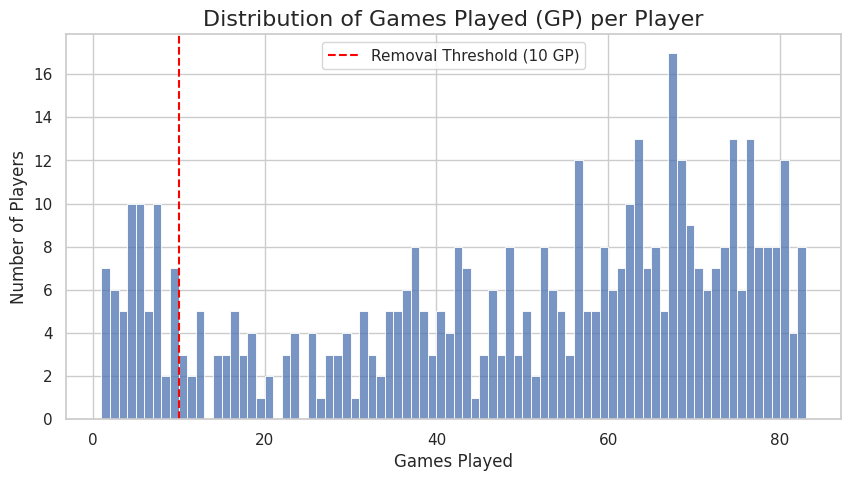

There are 62 players with < 10 games played.
Examples of players to be removed:
        Player Name  GP    MP  PTS
17     Kemba Walker   9  16.0  8.0
141    Daniel Theis   7  15.6  7.0
162     Cody Martin   7  19.1  5.0
221   Dylan Windler   3   3.3  1.7
247  Sterling Brown   4   6.0  0.0

Removed 62 players.
Remaining players in dataset: 405


In [9]:
# Plot distribution of Games Played (GP)
plt.figure(figsize=(10, 5))
sns.histplot(df_cleaned['GP'], bins=82, kde=False)
plt.title('Distribution of Games Played (GP) per Player', fontsize=16)
plt.xlabel('Games Played', fontsize=12)
plt.ylabel('Number of Players', fontsize=12)
plt.axvline(x=10, color='red', linestyle='--', label='Removal Threshold (10 GP)')
plt.legend()
plt.show()

# See how many players have < 10 GP
low_gp_players = df_cleaned[df_cleaned['GP'] < 10]
print(f"There are {len(low_gp_players)} players with < 10 games played.")
print("Examples of players to be removed:")
print(low_gp_players[['Player Name', 'GP', 'MP', 'PTS']].head())

# Apply the removal
original_player_count = len(df_cleaned)
df_processed = df_cleaned[df_cleaned['GP'] >= 10].copy()
removed_count = original_player_count - len(df_processed)

print(f"\nRemoved {removed_count} players.")
print(f"Remaining players in dataset: {len(df_processed)}")

In [10]:
# 1. Simplify 'Position'
# We take only the primary position (e.g., 'PG-SG' becomes 'PG')
df_processed['Position_Simple'] = df_processed['Position'].apply(lambda x: x.split('-')[0])

# 2. Simplify 'Team'
# We group traded players (e.g., 'LAL/LAC') into a 'Multiple' category
df_processed['Team_Simple'] = df_processed['Team'].apply(lambda x: 'Multiple' if '/' in x else x)

# 3. Define feature lists
# We drop the original, non-simplified categorical columns and the player name
features_to_drop = ['Player Name', 'Position', 'Team']
df_features = df_processed.drop(columns=features_to_drop)

categorical_features = ['Position_Simple', 'Team_Simple']
numeric_features = [col for col in df_features.columns if col not in categorical_features]

# 4. Create a ColumnTransformer pipeline
# This scales numeric data and one-hot encodes categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'
)

# 5. Apply the preprocessing
X_processed = preprocessor.fit_transform(df_features)

# Get feature names for later analysis (e.g., heatmap)
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = numeric_features + list(cat_feature_names)

print(f"Data shape after preprocessing: {X_processed.shape}")
print(f"Original numeric features: {len(numeric_features)}")
print(f"New categorical features: {len(cat_feature_names)}")
print(f"Total features after processing: {X_processed.shape[1]}")

# Keep player names and simple positions for later analysis
player_names = df_processed['Player Name'].values
player_positions = df_processed['Position_Simple'].values

Data shape after preprocessing: (405, 84)
Original numeric features: 48
New categorical features: 36
Total features after processing: 84


## Question 2.1(a)

In [11]:
# --- Question 2.1(a): Autoencoder ---

# Define constants based on your data shape
original_dim = X_processed.shape[1]  # This should be 84
encoding_dim = 2  # As required by the assignment

# --- Build the Autoencoder ---
input_layer = Input(shape=(original_dim,))

# Encoder
# We use a bottleneck structure. ReLU activation is a standard choice.
encoder = Dense(128, activation='relu')(input_layer)
encoder = Dense(64, activation='relu')(encoder)
encoder = Dense(32, activation='relu')(encoder)
# The final encoded layer gives us our 2D representation
encoded = Dense(encoding_dim, activation='relu', name='latent_space')(encoder)

# Decoder
# This attempts to reconstruct the original data from the 2D representation
decoder = Dense(32, activation='relu')(encoded)
decoder = Dense(64, activation='relu')(decoder)
decoder = Dense(128, activation='relu')(decoder)
# The output layer uses 'linear' activation because we are reconstructing
# scaled (non-binary) data, not probabilities.
decoded = Dense(original_dim, activation='linear')(decoder)

# Autoencoder model (for training)
autoencoder = Model(input_layer, decoded)

# Encoder model (for getting the reduced data)
encoder_model_ae = Model(input_layer, encoded)

# Compile the model
# We use 'mean_squared_error' as the loss, as we want the
# output to be as close to the input as possible.
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Set early stopping to prevent overfitting
# This will stop training if the validation loss doesn't improve
# for 10 consecutive epochs.
early_stopping = EarlyStopping(monitor='val_loss',
                             mode='min',
                             patience=10,
                             restore_best_weights=True)

# Train the autoencoder
print("--- Training Autoencoder (AE) ---")
history_ae = autoencoder.fit(
    X_processed, X_processed,  # Note: Input and target are the same
    epochs=100,
    batch_size=32,
    shuffle=True,
    validation_split=0.1,  # Use 10% of data for validation
    callbacks=[early_stopping],
    verbose=1  # Set to 0 if you want to silence the output
)

# Get the 2D reduced data by predicting with the encoder
X_reduced_ae = encoder_model_ae.predict(X_processed)

print("\n--- AE Training Complete ---")
print(f"AE reduced data shape: {X_reduced_ae.shape}")

--- Training Autoencoder (AE) ---
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.6025 - val_loss: 0.6711
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4890 - val_loss: 0.6558
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4486 - val_loss: 0.6215
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4237 - val_loss: 0.5634
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4074 - val_loss: 0.5033
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3919 - val_loss: 0.4667
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3442 - val_loss: 0.4279
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3067 - val_loss: 0.3952
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2681 - val_loss: 0.3711
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2600 - val_loss: 0.3522
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2543 - val_loss: 0.3317
Epoch 12/100
12/12 ━━━━━━━━━

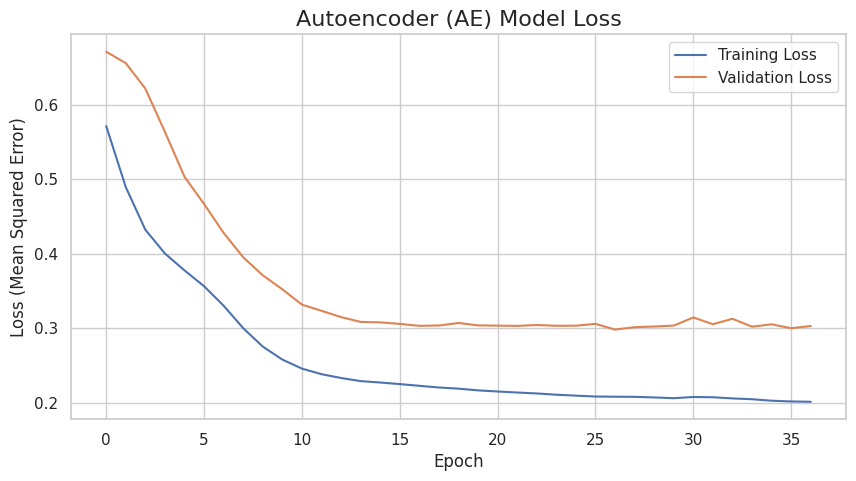

In [12]:
# Plot the training & validation loss curves
plt.figure(figsize=(10, 5))
plt.plot(history_ae.history['loss'], label='Training Loss')
plt.plot(history_ae.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder (AE) Model Loss', fontsize=16)
plt.ylabel('Loss (Mean Squared Error)', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend()
plt.show()

In [13]:
# The error message shows the 32-neuron layer is named 'dense_9'
# Encoder architecture: input_layer_1 (Input) -> dense_7 (128) -> dense_8 (64) -> dense_9 (32)
correct_layer_name = 'dense_2'

try:
    intermediate_layer_model = Model(inputs=autoencoder.input,
                                     outputs=autoencoder.get_layer(correct_layer_name).output)

    # Get the 32D representation
    X_reduced_32d_ae = intermediate_layer_model.predict(X_processed)

    print(f"Intermediate 32D data shape: {X_reduced_32d_ae.shape}")

except ValueError as e:
    print(f"Error: Could not find layer '{correct_layer_name}'.")
    print("Please run `autoencoder.summary()` to find the correct name for the 32-neuron Dense layer.")
    print(e)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Intermediate 32D data shape: (405, 32)


## Question 2.1(b)

In [14]:
# --- Question 2.1(b): Autoencoders + SOMs ---

# Data is the 32D latent space we just extracted
data_som = X_reduced_32d_ae

# We need to set the SOM grid size.
# A 20x20 grid (400 neurons) is a good fit for 405 data points.
map_w = 20
map_h = 20

# Initialise and train the SOM
# sigma and learning_rate are standard starting points.
som = MiniSom(map_w, map_h, data_som.shape[1],  # data.shape[1] is 32
              sigma=1.5,
              learning_rate=0.5,
              random_seed=42)

som.random_weights_init(data_som)
print("--- Training SOM ---")
som.train_random(data_som, 1000, verbose=True)  # 1000 iterations

# Get the 2D representation
# We find the "winner" neuron (Best Matching Unit, BMU) for each player.
X_reduced_som_raw = np.array([som.winner(x) for x in data_som])

# Add a little 'jitter' (small random noise)
# This is just for plotting, so all points don't stack on one neuron
# and hide each other.
X_reduced_som = X_reduced_som_raw.astype(float)
X_reduced_som += np.random.rand(X_reduced_som.shape[0], 2) * 0.5

print("\n--- SOM Training Complete ---")
print(f"AE+SOM reduced data shape: {X_reduced_som.shape}")

--- Training SOM ---
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.7730956879900527

--- SOM Training Complete ---
AE+SOM reduced data shape: (405, 2)


## Question 2.1(c)

In [15]:
# --- Question 2.1(c): Autoencoders + t-SNE ---

# Data is the 32D latent space
data_tsne = X_reduced_32d_ae

print("--- Running AE + t-SNE ---")
# Perplexity is the main parameter to tune; 30 is a standard default.
# init='pca' and learning_rate='auto' help stabilise the results.
tsne = TSNE(n_components=2,
            perplexity=30,
            n_iter=1000,
            random_state=42,
            init='pca',
            learning_rate='auto')

X_reduced_tsne = tsne.fit_transform(data_tsne)

print(f"AE+t-SNE reduced data shape: {X_reduced_tsne.shape}")

--- Running AE + t-SNE ---
AE+t-SNE reduced data shape: (405, 2)


## Question 2.1(d)

In [16]:
# --- Question 2.1(d): Autoencoders + UMAP ---

# Data is the 32D latent space
data_umap = X_reduced_32d_ae

print("--- Running AE + UMAP ---")
# n_neighbors and min_dist are the main parameters.
# 15 neighbors and 0.1 min_dist are standard defaults
# that balance local and global structure.

# ---- CORRECTION HERE ----
# We access the UMAP class directly from our 'umap' alias
umap_reducer = umap.UMAP(n_components=2,
                         n_neighbors=15,
                         min_dist=0.1,
                         random_state=42)

X_reduced_umap = umap_reducer.fit_transform(data_umap)

print(f"AE+UMAP reduced data shape: {X_reduced_umap.shape}")

--- Running AE + UMAP ---
AE+UMAP reduced data shape: (405, 2)


## Question 2.1(e)

In [19]:
# --- Question 2.1(e): Variational Autoencoder (Final Version 2.0) ---
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.callbacks import EarlyStopping

# --- FORCE CPU ---
try:
    tf.config.set_visible_devices([], 'GPU')
    print("GPU disabled. Running on CPU.")
except Exception as e:
    print(f"Could not disable GPU, proceeding anyway. Error: {e}")

# --- 1. Define the Encoder ---
original_dim = X_processed.shape[1]
intermediate_dim = 64
latent_dim = 2

encoder_inputs = Input(shape=(original_dim,))
x = Dense(intermediate_dim, activation="relu")(encoder_inputs)
z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)

def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, name='z')([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# --- 2. Define the Decoder ---
latent_inputs = Input(shape=(latent_dim,))
x = Dense(intermediate_dim, activation="relu")(latent_inputs)
decoder_outputs = Dense(original_dim, activation="linear")(x)
decoder = Model(latent_inputs, decoder_outputs, name="decoder")

# --- 3. Define the VAE by subclassing ---
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        x = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x)
            reconstruction = self.decoder(z)

            # --- CORRECTION: Using the MeanSquaredError CLASS ---
            reconstruction_loss = tf.reduce_mean(
                 tf.keras.losses.MeanSquaredError()(x, reconstruction) * original_dim
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        x = data
        z_mean, z_log_var, z = self.encoder(x)
        reconstruction = self.decoder(z)

        # --- CORRECTION: Using the MeanSquaredError CLASS ---
        reconstruction_loss = tf.reduce_mean(
             tf.keras.losses.MeanSquaredError()(x, reconstruction) * original_dim
        )
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + kl_loss

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {m.name: m.result() for m in self.metrics}

# --- 4. Instantiate and Train the VAE Model ---
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())

print("--- Training VAE on CPU (Final Version 2.0) ---")
split = int(len(X_processed) * 0.9)
x_train = X_processed[:split]
x_val = X_processed[split:]

history_vae = vae.fit(
    x_train,
    epochs=100,
    batch_size=16,
    validation_data=x_val,
    callbacks=[EarlyStopping(monitor='val_total_loss', patience=10, mode='min', restore_best_weights=True)],
    verbose=1
)

# --- 5. Get the 2D Representation ---
X_reduced_vae = vae.encoder.predict(X_processed)[0]

print("\n--- VAE Training Complete ---")
print(f"VAE reduced data shape: {X_reduced_vae.shape}")

GPU disabled. Running on CPU.
--- Training VAE on CPU (Final Version 2.0) ---
Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - kl_loss: 0.7533 - reconstruction_loss: 49.0629 - total_loss: 49.8163 - val_kl_loss: 0.7219 - val_reconstruction_loss: 55.6942 - val_total_loss: 56.4161
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - kl_loss: 0.5824 - reconstruction_loss: 47.4670 - total_loss: 48.0494 - val_kl_loss: 1.7996 - val_reconstruction_loss: 51.0313 - val_total_loss: 52.8309
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - kl_loss: 2.4164 - reconstruction_loss: 38.4587 - total_loss: 40.8752 - val_kl_loss: 5.0775 - val_reconstruction_loss: 37.6602 - val_total_loss: 42.7377
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - kl_loss: 3.4578 - reconstruction_loss: 33.3140 - total_loss: 36.7719 - val_kl_loss: 4.3779 - val_reconstruction_loss: 36.0294 - val_total_loss: 40.4073
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - kl_loss: 2.9802 - reconstruction_loss: 30.2431 -

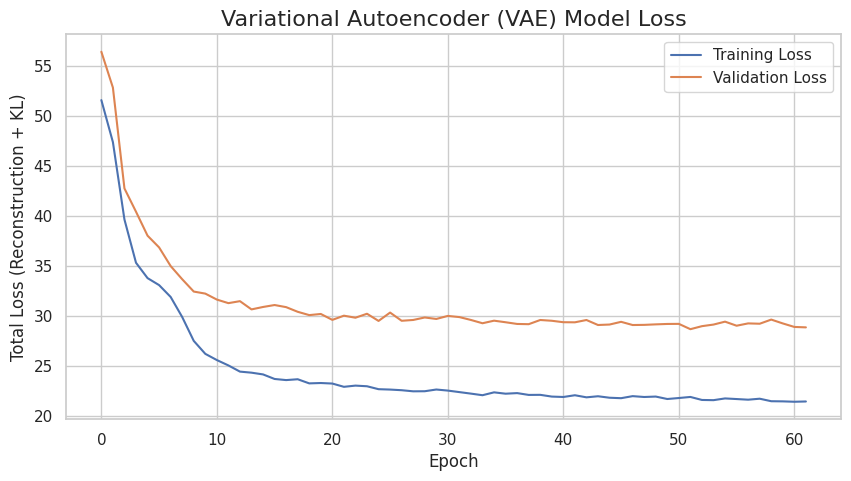

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(history_vae.history['total_loss'], label='Training Loss')
plt.plot(history_vae.history['val_total_loss'], label='Validation Loss')
plt.title('Variational Autoencoder (VAE) Model Loss', fontsize=16)
plt.ylabel('Total Loss (Reconstruction + KL)', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend()
plt.show()

## Question 2.2

--- Running Elbow Method on AE+UMAP data ---


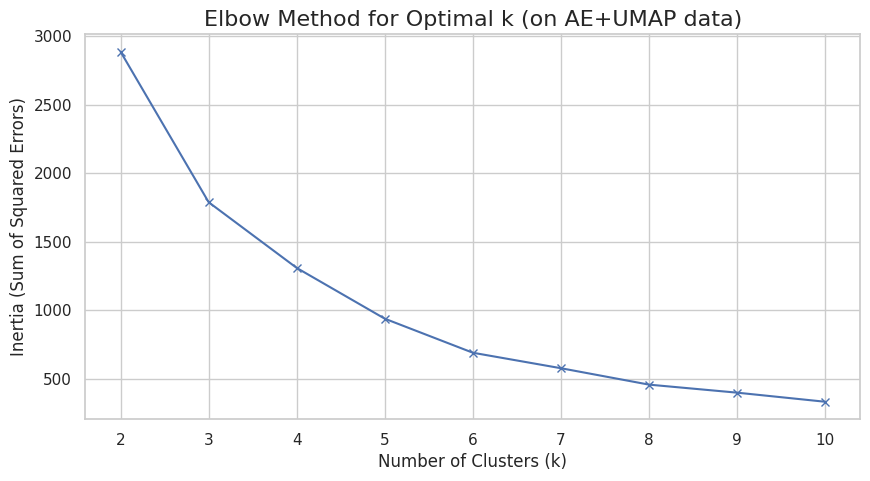

In [21]:
# --- Question 2.2: Finding Optimal k ---

# Store all the reduced datasets we've created into a dictionary
reduced_data = {
    'Autoencoder (AE)': X_reduced_ae,
    'VAE': X_reduced_vae,
    'AE + SOM': X_reduced_som,
    'AE + t-SNE': X_reduced_tsne,
    'AE + UMAP': X_reduced_umap
}

# It's good practice to scale the outputs of the AE, VAE, and SOM
# before clustering, as k-Means is distance-based. t-SNE and UMAP
# outputs are primarily for visualisation and often don't require scaling.
scaler = StandardScaler()
reduced_data['Autoencoder (AE)'] = scaler.fit_transform(reduced_data['Autoencoder (AE)'])
reduced_data['VAE'] = scaler.fit_transform(reduced_data['VAE'])
reduced_data['AE + SOM'] = scaler.fit_transform(reduced_data['AE + SOM'])

# --- Elbow Method ---
# We will calculate the Sum of Squared Errors (Inertia) for k from 2 to 10
sse = {}
K_range = range(2, 11)

print("--- Running Elbow Method on AE+UMAP data ---")
# Use the unscaled UMAP data for finding k
data_for_k = reduced_data['AE + UMAP']

for k in K_range:
    # n_init='auto' is the modern default to handle initialisation smartly
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(data_for_k)
    sse[k] = kmeans.inertia_

# Plot the Elbow curve
plt.figure(figsize=(10, 5))
plt.plot(list(sse.keys()), list(sse.values()), 'bx-')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia (Sum of Squared Errors)', fontsize=12)
plt.title('Elbow Method for Optimal k (on AE+UMAP data)', fontsize=16)
plt.xticks(K_range)
plt.show()

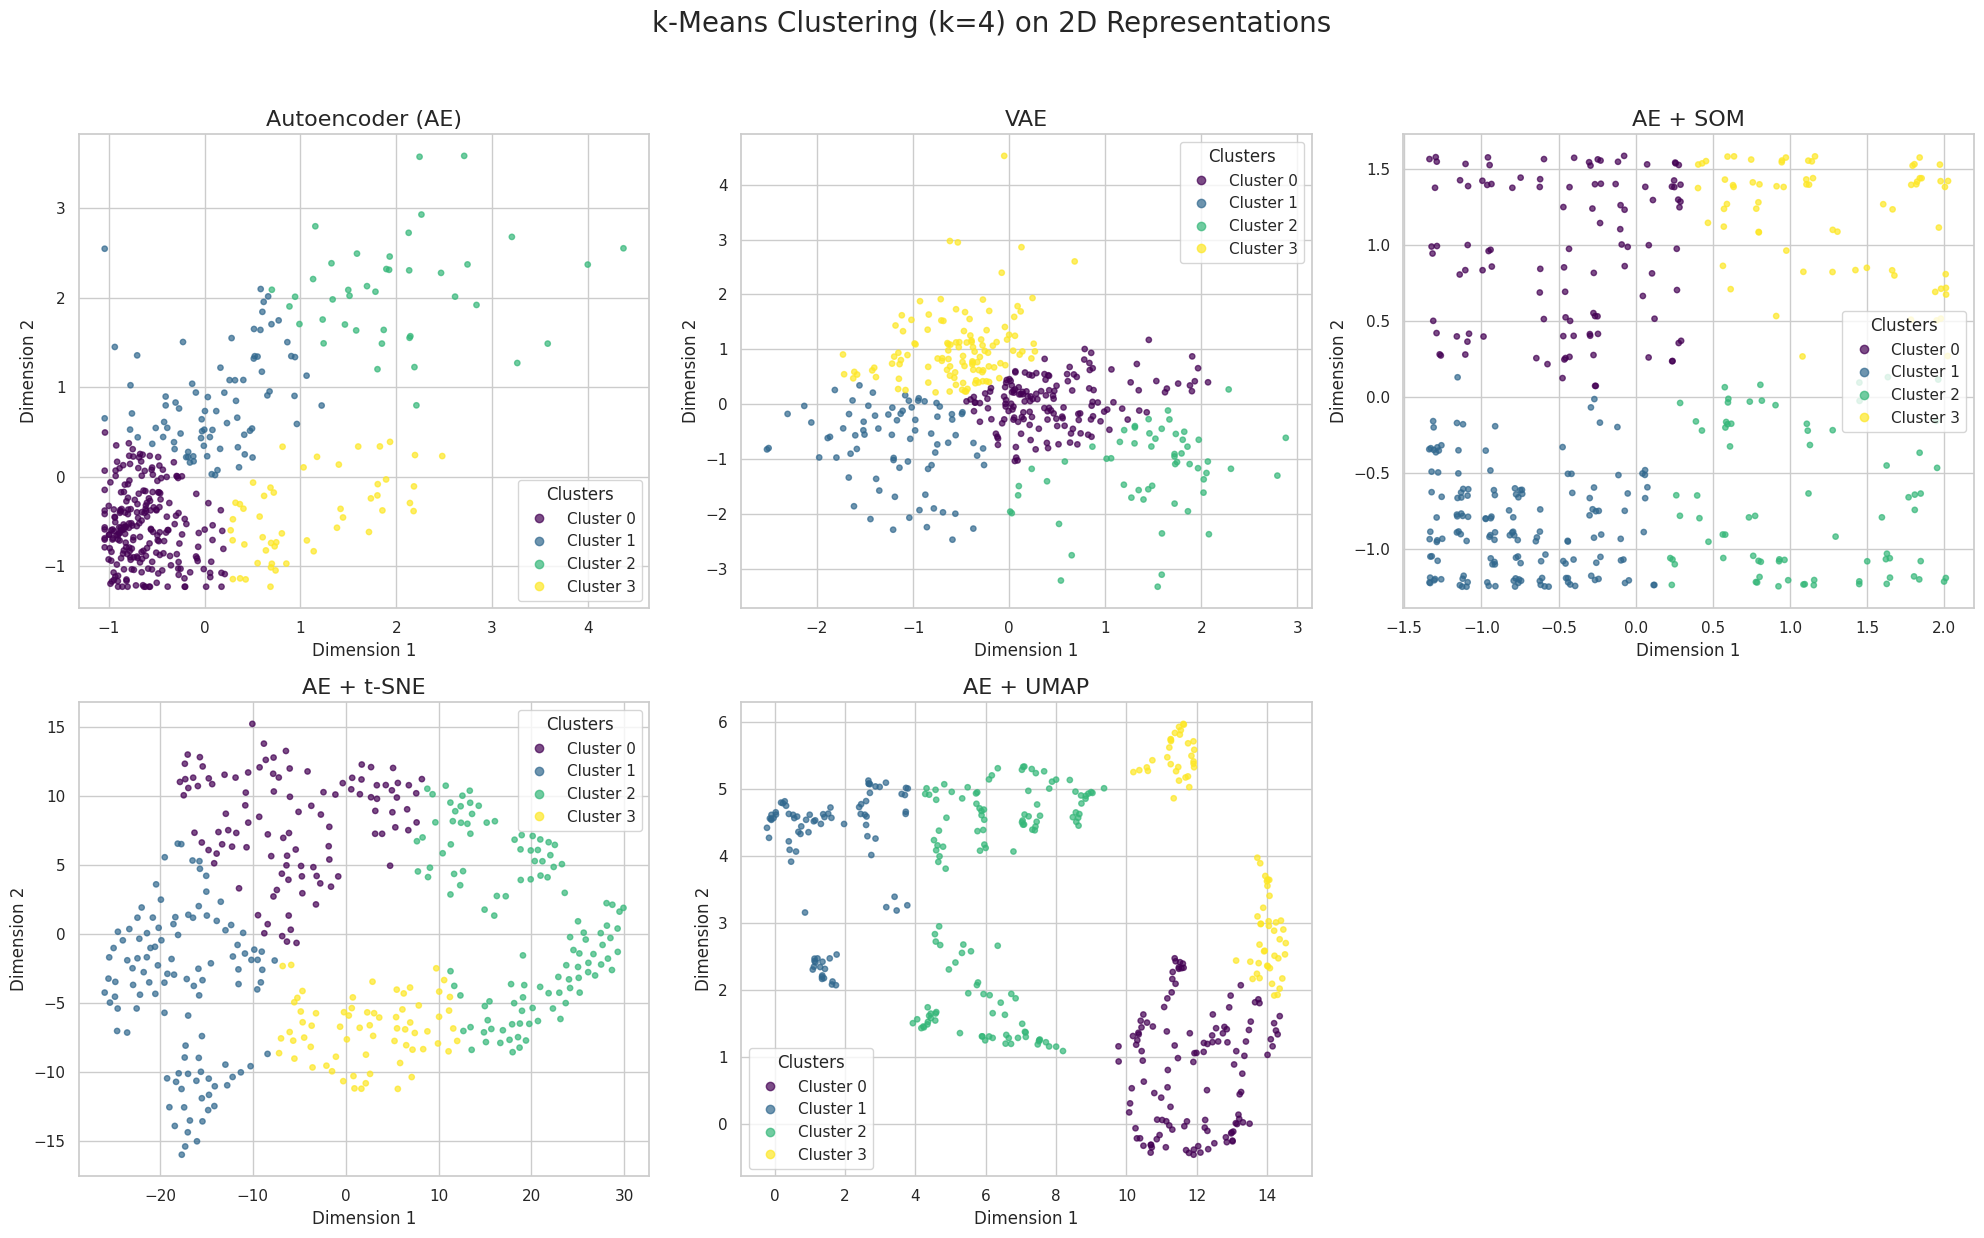

In [23]:
# --- Question 2.2: Visualise All Clustered Datasets (Corrected) ---

# The optimal k was determined to be 4.
K_OPTIMAL = 4

df_analysis = df_processed.copy()

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle(f'k-Means Clustering (k={K_OPTIMAL}) on 2D Representations', fontsize=20, y=1.03)
axes = axes.flatten()

for i, (title, data) in enumerate(reduced_data.items()):
    kmeans = KMeans(n_clusters=K_OPTIMAL, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(data)

    clean_name = title.replace(' (AE)', '').replace('AE + ', '').replace(' ', '_')
    df_analysis[f'Cluster_{clean_name}'] = labels

    ax = axes[i]
    scatter = ax.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', s=15, alpha=0.7)

    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Dimension 1')

    # --- CORRECTION HERE ---
    # The correct method is set_ylabel()
    ax.set_ylabel('Dimension 2')

    legend_elements = scatter.legend_elements()
    ax.legend(handles=legend_elements[0], labels=[f'Cluster {j}' for j in range(K_OPTIMAL)], title="Clusters")

axes[5].set_visible(False)

plt.tight_layout()
plt.show()

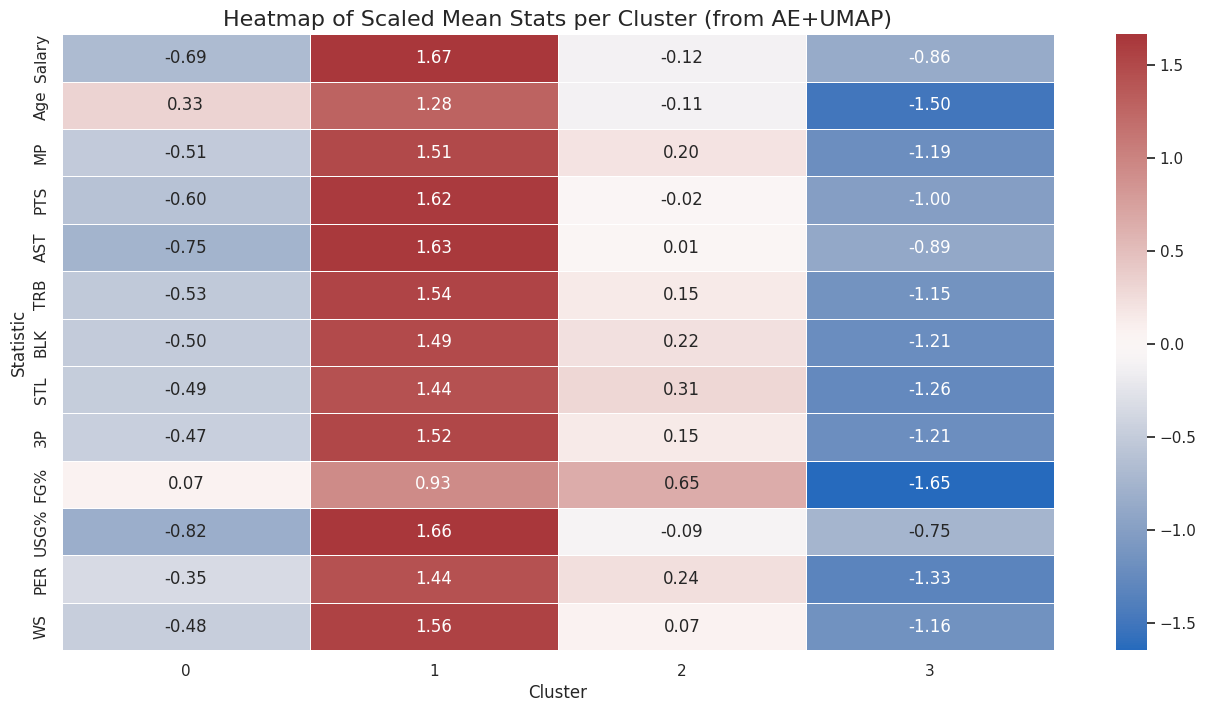


--- Position Distribution per Cluster (AE+UMAP) ---
Position_Simple   C  PF  PG  SF  SG
Cluster_UMAP                       
0                16  35   8  31  31
1                22  15  20  11  15
2                42  15  21  18  34
3                 3  11  17  19  21


In [24]:
# --- Question 2.2: Explore and Interpret the Results ---

# We will analyse the clusters from the 'AE + UMAP' method,
# as it provided the clearest visual separation.
cluster_col_to_analyse = 'Cluster_UMAP'

# Let's select a subset of important, interpretable stats for our analysis.
key_stats = [
    'Salary', 'Age', 'MP', 'PTS', 'AST', 'TRB', 'BLK', 'STL',
    '3P', 'FG%', 'USG%', 'PER', 'WS' # Win Shares
]
analysis_df = df_analysis[key_stats + ['Position_Simple', cluster_col_to_analyse]]

# --- 1. Analyse Mean Statistics per Cluster ---
# Group by cluster and calculate the average for our key stats.
cluster_analysis_mean = analysis_df.groupby(cluster_col_to_analyse)[key_stats].mean()

# To compare these stats fairly (e.g., Salary vs. BLK), we must scale them.
# This shows how each cluster's average compares to the overall average.
cluster_mean_scaled = StandardScaler().fit_transform(cluster_analysis_mean)
cluster_mean_scaled_df = pd.DataFrame(cluster_mean_scaled,
                                      index=cluster_analysis_mean.index,
                                      columns=cluster_analysis_mean.columns)

# Plot the results on a heatmap for clear visualisation.
plt.figure(figsize=(16, 8))
sns.heatmap(cluster_mean_scaled_df.T, annot=True, fmt=".2f", cmap="vlag", center=0, linewidths=.5)
plt.title('Heatmap of Scaled Mean Stats per Cluster (from AE+UMAP)', fontsize=16)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Statistic', fontsize=12)
plt.show()

# --- 2. Analyse Position Distribution per Cluster ---
# A crosstab shows the count of each player position in each cluster.
position_distribution = pd.crosstab(analysis_df[cluster_col_to_analyse], analysis_df['Position_Simple'])

print("\n--- Position Distribution per Cluster (AE+UMAP) ---")
print(position_distribution)